In [2]:
import pystac_client
import geogif
import stackstac
import os
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import glob

In [3]:
load_dotenv()

os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')

# Other variables
os.environ['GDAL_HTTP_TCP_KEEPALIVE'] = "YES"
os.environ['AWS_S3_ENDPOINT'] = "eodata.dataspace.copernicus.eu"
os.environ['AWS_HTTPS'] = "YES"
os.environ['AWS_VIRTUAL_HOSTING'] = "FALSE"
os.environ["GDAL_HTTP_UNSAFESSL"] = "YES"

In [4]:
URL = "https://stac.dataspace.copernicus.eu/v1"
cat = pystac_client.Client.open(URL)
cat.add_conforms_to("ITEM_SEARCH")

In [5]:
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [19.77, 50.00],
            [20.16, 50.00],
            [20.16, 50.15],
            [19.77, 50.15],
            [19.77, 50.00],
        ]
    ],
}

In [6]:
params = {
    "max_items": 100,
    "collections": "sentinel-2-l1c",
    "datetime": "2025-04-01/2025-05-17",
    "intersects": geom,
    "query": {"eo:cloud_cover": {"lte": 1}},
    "sortby": "properties.eo:cloud_cover",
    "fields": {"exclude": ["geometry"]},
}

items = list(cat.search(**params).items_as_dicts())
print(f"Found {len(items)} items.")

cloud_cover_values = [item["properties"]["eo:cloud_cover"] for item in items]
cloud_cover_values

#items[0]

Found 4 items.


[0.044731105736, 0.097217319627, 0.195317865568, 0.918125341016]

In [7]:
stack = stackstac.stack(
    items=items,
    resolution=(10, 10),
    bounds_latlon=(19.77, 50.00, 20.16, 50.15),
    chunksize=98304,
    epsg=32634,
    gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
        {
            "GDAL_NUM_THREADS": -1,
            "GDAL_HTTP_UNSAFESSL": "YES",
            "GDAL_HTTP_TCP_KEEPALIVE": "YES",
            "AWS_VIRTUAL_HOSTING": "FALSE",
            "AWS_HTTPS": "YES",
        }
    ),
)

In [8]:
rgb = stack.sel(band=["B04", "B03", "B02"])
B08 = stack.sel(band="B08")
B04 = stack.sel(band="B04")
B03 = stack.sel(band="B03")
B01 = stack.sel(band="B01")

#gif = geogif.dgif(rgb, fps=0.5).compute()
#gif

In [9]:
Chl_a = 4.26 * (B03 / B01) ** 3.94
Turb = 8.93 * (B03 / B01) - 6.39
CDOM = 537 * np.exp(-2.93 * B03 / B04)
DOC = 432 * np.exp(-2.24 * B03 / B04)
NDWI = (B03 - B08) / (B03 + B08)
#print(Chl_a['time'].values)
#len(Chl_a['time'])

In [26]:
import rasterio
import numpy as np

# Utwórz maskę wody (NDWI > 0)
water_mask = NDWI > 0.1

# Stwórz obraz binarny: 1 = woda, 0 = nie-woda
water_only = np.where(water_mask, 1, 0).astype('uint8')


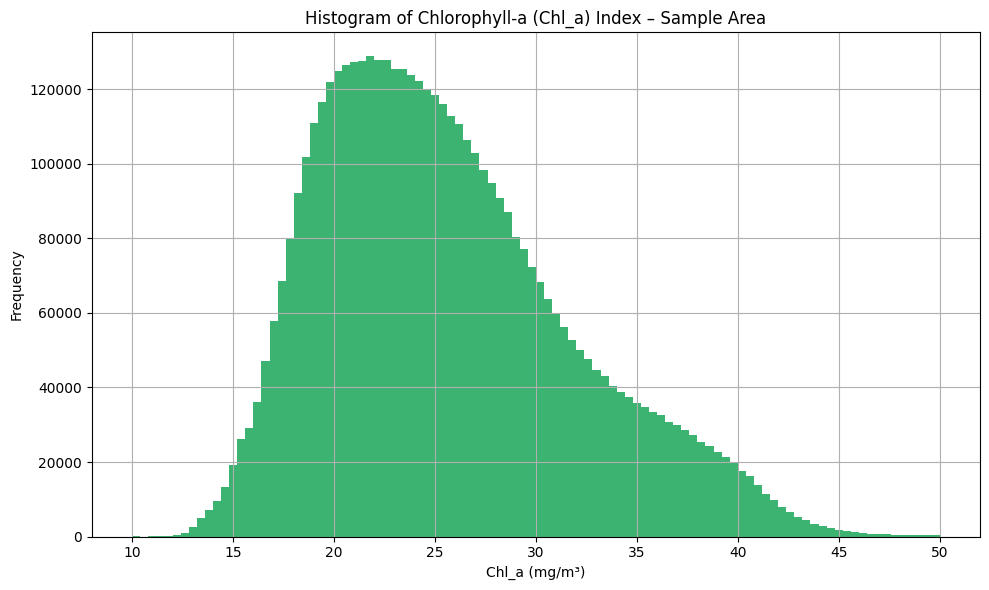

In [28]:
# Extract the layer
layer = CDOM.isel(time=1)

# Mask out invalid data: NaNs, values > 10000, and optionally zeros
clean_layer = layer.where((layer > 10) & (layer <= 50))

# Now plot the cleaned histogram
plt.figure(figsize=(10, 6))
plt.hist(clean_layer.values.flatten(), bins=100, color='mediumseagreen')
plt.title("Histogram of Chlorophyll-a (Chl_a) Index – Sample Area")
plt.xlabel("Chl_a (mg/m³)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


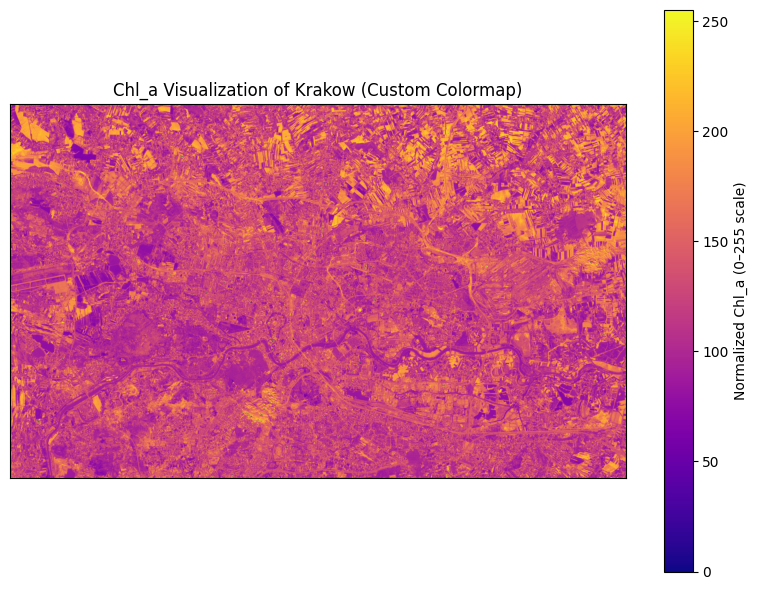

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

normalized = ((clean_layer / 50) * 255).astype('uint8')

spectral_colormap = plt.get_cmap('plasma', 256)
se2waq_colormap = [spectral_colormap(i) for i in range(256)]
cmap = ListedColormap(se2waq_colormap)

plt.figure(figsize=(8, 6))
plt.imshow(normalized, cmap=cmap, vmin=0, vmax=255)
plt.colorbar(label='Normalized Chl_a (0–255 scale)')
plt.title("Chl_a Visualization of Krakow (Custom Colormap)")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

# Create figure and axis without ticks or labels
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
ax.axis('off')  # Remove axes completely
ax.imshow(normalized, cmap=cmap, vmin=0, vmax=255)

# Save with no padding or border
fig.savefig("chl_a_map_only.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

In [ ]:
layer =water_mask.isel(time=1)
plt.figure(figsize=(8, 6))
plt.imshow(layer)
plt.colorbar()
plt.title("Water Mask Visualization of Krakow")
plt.xticks([])
plt.yticks([])
plt.show()

NameError: name 'Chl_a' is not defined

In [22]:
chl_water_only = np.where(water_mask, Turb, np.nan)


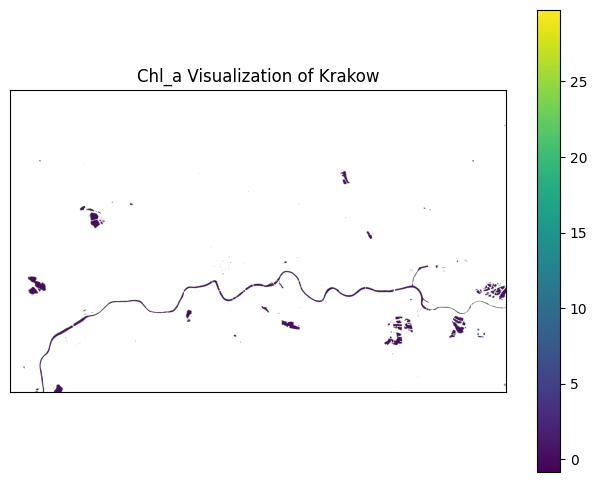

In [23]:
# Assuming 'layer' has shape (4, 1708, 2814)

layer =chl_water_only
layer_transposed = np.transpose(layer, (1, 2, 0))
single_band = layer[0, :, :]
plt.figure(figsize=(8, 6))
plt.imshow(single_band)
plt.colorbar()
plt.title("Chl_a Visualization of Krakow")
plt.xticks([])
plt.yticks([])
plt.show()


In [19]:
import geopandas as gpd

# GeoJSON request from ArcGIS REST API
url = "https://msip.um.krakow.pl/arcgis/rest/services/Obserwatorium/K09_HYDROGRAFIA/MapServer/0/query"
params = {
    "where": "1=1",
    "outFields": "*",
    "f": "geojson"
}

# Full URL
from urllib.parse import urlencode
full_url = f"{url}?{urlencode(params)}"

# Read to GeoDataFrame
gdf = gpd.read_file(full_url)

# Save to shapefile
gdf.to_file("krakow_water.shp")



CRS: EPSG:4326


<Figure size 1000x1000 with 0 Axes>

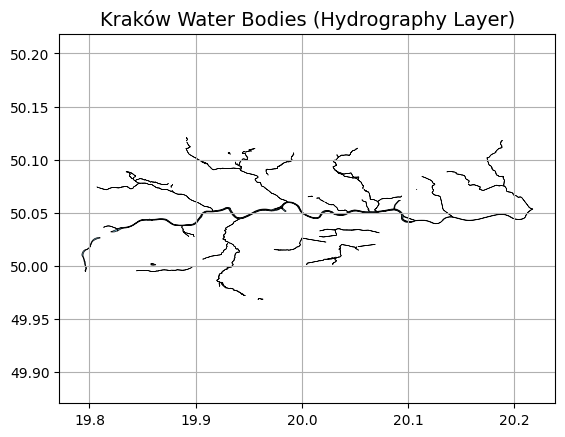

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
shp_path = "krakow_water.shp"
gdf = gpd.read_file(shp_path)

# Check projection (optional)
print("CRS:", gdf.crs)

# Plot the shapefile
plt.figure(figsize=(10, 10))
gdf.plot(color='skyblue', edgecolor='black', linewidth=0.5)
plt.title("Kraków Water Bodies (Hydrography Layer)", fontsize=14)
plt.axis("equal")
plt.grid(True)
plt.show()


In [ ]:
import geopandas as gpd
import rioxarray
import xarray as xr


chl_a_clipped = Chl_a.rio.clip(krakow_water.shp.geometry, krakow_water.crs, drop=True)

